In [1]:
%load_ext autoreload
%autoreload 2

import os, sys
import argparse
import pickle
import numpy as np
from tqdm import tqdm

import torch.nn as nn
import torch
import torchvision.models as models
import matplotlib.pyplot as plt

# from randomize import RandomPixel, RandomWavelet, PixelRDE, CartoonX_exp

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

sys.path.insert(1, os.path.join(sys.path[0], '../'))

from utils import hparams_to_str, get_files

from cartoonX import CartoonX
from pixelRDE import PixelRDE


c:\Users\elias\anaconda3\envs\fact2\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
l1lambdas = np.power(2, np.arange(2, 7))

storedir = '../logs/experiments/lambda_exploration_all'
logdir = '../logs/explanations/lambda_exploration_all'



In [3]:
model = (models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1).eval().to(device))

In [35]:
class CartoonX_exp(CartoonX):
    def __init__(self, **kwargs) -> None:
        super().__init__(**kwargs)

    def initialize_dwt_mask(self, yl, yh, path=None, epsilon = 0):
        assert self.init_mask == 'lambda_inference'

        with open(path, 'rb') as f:
            yl, yh = mask_CartoonX = pickle.load(f)
            
        yl = torch.from_numpy(yl).unsqueeze(0)
        yh = [torch.from_numpy(y).unsqueeze(0) for y in yh]
        
        s_yl = yl.requires_grad_(True).to(self.device)

        s_yh = []
        for y in yh:
            s_yh.append(y.requires_grad_(True).to(self.device))

        # Get total number of mask entries
        num_mask_entries = s_yl.shape[-1] * s_yl.shape[-2]
        for s in s_yh:
            num_mask_entries += s.shape[-1] * s.shape[-2] * s.shape[-3]

        return s_yl, s_yh, num_mask_entries


class PixelRDE_exp(PixelRDE):
    def __init__(self, **kwargs) -> None:
        super().__init__(**kwargs)

    # def __call__(self, yl, yh, path, epsilon=1):
    def __call__(self, x, target, path):
        """
        args:
            x: torch.Tensor - input image
            target: int or torch.Tensor - target label if int otherwise target output probabilities
            save_mask_after: list - list of optimization steps at which the intermediate mask is stored
        """
        # Assert image has shape (1,C,H,W)
        assert len(x.shape) == 4
        x.requires_grad_(False)
        
        # Initialize list for logs
        logs = {"l1-norm": [], "distortion": [], "loss": []}
        
        """
        Compute standard deviation and mean for Gaussian noise (the obfuscation strategy used in the paper)
        """
        std_pixel = torch.std(x)
        mean_pixel = torch.mean(x)
        
        """
        Initialize pixel mask
        """
        if self.init_mask == "lambda_inference":
            
            # load exp_pixelRDE.npy
            s = np.load(path)
            s = torch.from_numpy(s).unsqueeze(0)
            s = s.requires_grad_(True).to(self.device)
        else:
            raise NotImplementedError(f"mask initialzation {self.init_mask} was not implemented.")


        # Get total number of mask entries
        num_mask_entries = s.shape[-1] * s.shape[-2]

        """
        Initialize Optimizer for mask
        """
        optimizer = torch.optim.Adam([s], lr=self.step_size)

        """
        Compute score for input image
        """
        if self.distortion_measure == "l2":
            # Measure distortion as squared ell_2 in output probabilities 
            score = self.softmax(self.model(x.detach()).detach())
        else:
            raise NotImplementedError(f"distortion measure {self.distortion_measure} was not implemented.")
        
        
        """
        Start optimizing masks
        """
        intermediate_masks = []

        """
        Compute distortion and sparsity
        """
        distortion, sparsity = self.step(std_pixel, mean_pixel, x, s, target, score, num_mask_entries)

        # Compute loss
        loss = distortion + self.l1lambda * sparsity
        
        # Log loss terms
        logs["distortion"].append(distortion.detach().clone().item())
        logs["l1-norm"].append(sparsity.detach().clone().item())
        logs["loss"].append(loss.detach().clone().item())


        # Clamp masks into [0,1]
        with torch.no_grad():
            s.clamp_(0,1)

        return s.detach().squeeze(0), logs, intermediate_masks # s is the mask in pixel space, 
    

n_images = int( len(os.listdir(logdir)) / len(l1lambdas) )
# n_images = 10
print(f"Found {n_images} images in {logdir}.")


data = {
        'dists_CNX' : np.zeros((len(l1lambdas), n_images)),
        'sparsities_CNX' : np.zeros((len(l1lambdas), n_images)),
        'dists_RDE' : np.zeros((len(l1lambdas), n_images)),
        'sparsities_RDE' : np.zeros((len(l1lambdas), n_images)),
    }



for i, l1lambda in enumerate(l1lambdas):
        files = get_files(logdir, l1lambda)

        files = files[:n_images]


        cartoonX = CartoonX_exp(
            model=model,
            device=device,
            batch_size= 1,
            num_steps = 1,
            step_size = 0.001,
            l1lambda = l1lambda,
            wave = "db3",
            mode = "zero",
            J = 5,
            preoptimization_step_size = 0.01,
            distortion_measure = 'l2',
            obfuscation_strategy="gaussian-adaptive-noise", 
            init_mask="lambda_inference",
        )

        pixelRDE = PixelRDE_exp(
            model=model,
            device=device,
            batch_size= 1,
            num_steps = 1,
            step_size = 0.001,
            l1lambda = l1lambda,
            distortion_measure = 'l2',
            init_mask="lambda_inference",
        )


        for j, file in enumerate(tqdm(files)):

            # Load original image
            x = np.load(os.path.join(logdir, file, 'original_image.npy'))
            x = torch.from_numpy(x)
            x = x.to(device)


            _, _, logs_cartoonX, _ = cartoonX(
                x.unsqueeze(0),
                target=None,
                path=os.path.join(logdir, file, 'DWTmask_cartoonX.pickle'),
            )

            _, logs_pixelRDE, _ = pixelRDE(
                x.unsqueeze(0),
                target=None,
                path=os.path.join(logdir, file, 'exp_pixelRDE.npy'),
            )

            assert len(logs_cartoonX['distortion']) == 1

            data['dists_CNX'][i][j] = logs_cartoonX['distortion'][0]
            data['dists_RDE'][i][j] = logs_pixelRDE['distortion'][0]
            data['sparsities_CNX'][i][j] = logs_cartoonX['l1-norm'][0]
            data['sparsities_RDE'][i][j] = logs_pixelRDE['l1-norm'][0]


Found 85 images in ../logs/explanations/lambda_exploration_all.


100%|██████████| 85/85 [00:23<00:00,  3.63it/s]


# Plotting

In [61]:
blue, red = '#00adee', '#ff0000'

linestyles = {'cartoonX' : '-', 'pixel_rde' : '-', 'random_pixel' : '--', 'random_wavelet' : '--'}
colors = {'cartoonX' : blue, 'pixel_rde' : red, 'random_pixel' : red, 'random_wavelet' : blue}
labels = {'cartoonX' : 'CartoonX', 'pixel_rde' : 'Pixel RDE', 'random_pixel' : 'Random Pixel', 'random_wavelet' : 'Random Wavelets'}

linestyles_c = {'dists_CNX' : '-', 'dists_RDE' : '-', 'sparsities_CNX' : '--', 'sparsities_RDE' : '--'}
colors_c = {'dists_CNX' : blue, 'dists_RDE' : red, 'sparsities_CNX' : blue, 'sparsities_RDE' : red}
labels_c = {'dists_CNX' : 'CartoonX Distortion', 'dists_RDE' : 'Pixel RDE Distortion', 'sparsities_CNX' : r'Cartoon X $10||s||_1/k$', 'sparsities_RDE' : r'Pixel RDE X $10||s||_1/k$'}

fontsize = 22
figsize = (8, 4)
plt.rcParams.update({'font.size': fontsize})


In [37]:
import copy

(5, 85)


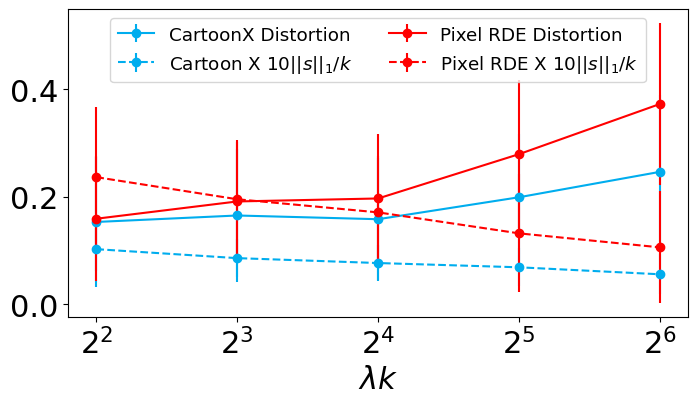

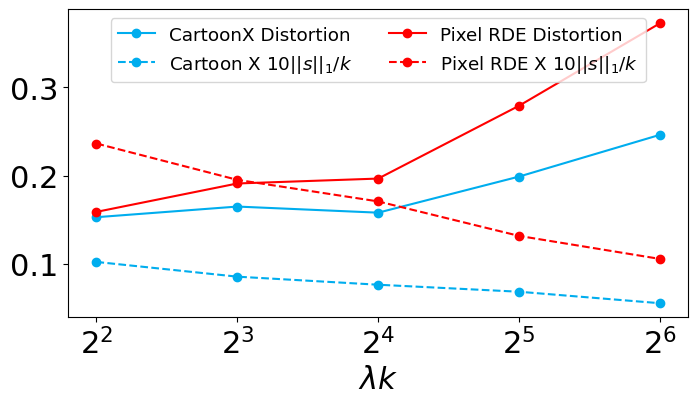

In [62]:
l1lambdas = np.power(2, np.arange(2, 7))
experiment_c = 'lambda_exploration_all'
plot_stds_c= [True, False]

data_c = copy.deepcopy(data)

data_c['sparsities_CNX'] = data_c['sparsities_CNX'] * 10
data_c['sparsities_RDE'] = data_c['sparsities_RDE'] * 10

print(data_c['dists_CNX'].shape)

for plot_std in plot_stds_c:

    fig, ax = plt.subplots(1, 1, figsize=figsize)

    for key, value in data_c.items():
        mean, std = np.mean(value, axis = 1), np.std(value, axis = 1)

        if plot_std:
            ax.errorbar(l1lambdas, mean, yerr = std, label=labels_c[key], linestyle=linestyles_c[key], color=colors_c[key], marker = 'o')
        else:
            ax.plot(l1lambdas, mean, label=labels_c[key], linestyle=linestyles_c[key], color=colors_c[key], marker = 'o')

        ax.legend(loc = 'upper center', ncol = 2, fontsize = fontsize*0.6)
        ax.set_xscale('log')

        ax.set_xticks(l1lambdas)
        ax.set_xticklabels([fr'$2^{i.astype(int)}$' for i in np.log2(l1lambdas)]) # Plot xticks as power of 2
        ax.tick_params(axis='x', which='minor', bottom=False) # Turn off minor ticks 

    ax.set_xlabel(r'$\lambda k$')
    # fig.savefig(f'figures/7c.pdf', bbox_inches='tight')

    plt.show()
